# Previsão de valores do aluguel de imóveis no município de São Paulo

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [36]:
df = pd.read_csv('./dados/data.csv')

## Análise dos dados

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [38]:
df.describe()

,area,bedrooms,garage,rent,total
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,84.655658,1.966286,1.060393,3250.814789,4080.030625
std,74.020536,0.931313,1.132349,2650.711557,3352.480274
min,0.000000,0.000000,0.000000,500.000000,509.000000
25%,40.000000,1.000000,0.000000,1590.000000,1996.000000
50%,60.000000,2.000000,1.000000,2415.000000,3057.000000
75%,96.000000,3.000000,2.000000,3800.000000,4774.000000
max,580.000000,6.000000,6.000000,25000.000000,28700.000000


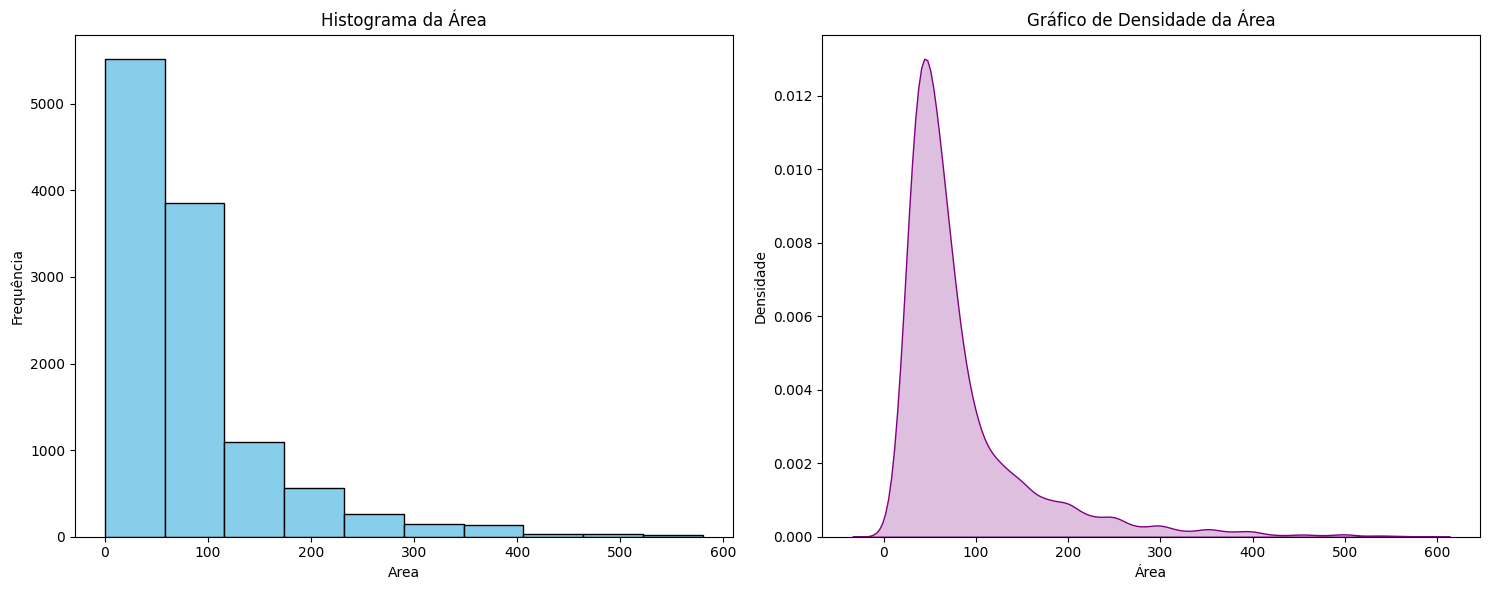

In [39]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma (usando Matplotlib)
axes[0].hist(df.area, bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Histograma da Área')
axes[0].set_xlabel('Area')
axes[0].set_ylabel('Frequência')

# Gráfico de Densidade (KDE Plot - usando Seaborn)
sns.kdeplot(data=df, x='area', fill=True, color='purple', ax=axes[1])
axes[1].set_title('Gráfico de Densidade da Área')
axes[1].set_xlabel('Área')
axes[1].set_ylabel('Densidade')

plt.tight_layout()
plt.show()


count    11657.000000
mean        84.655658
std         74.020536
min          0.000000
25%         40.000000
50%         60.000000
75%         96.000000
max        580.000000
Name: area, dtype: float64

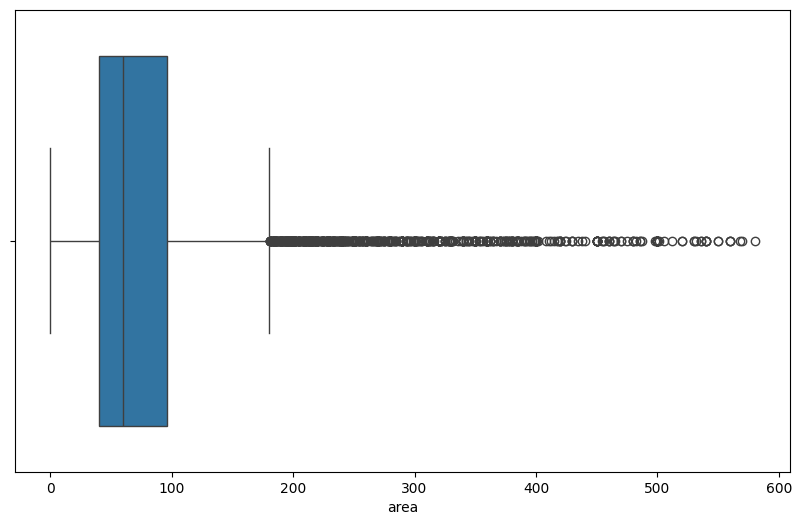

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Verificando a area do menor valor de aluguel

In [41]:
df[df.rent == 500]

,address,district,area,bedrooms,garage,type,rent,total
51,Rua Tanque Velho,Vila Nivi,45,1,0,Casa,500,551
1188,Viela Renaldo Laporta,Vila Aurora (zona Norte),30,1,0,Casa,500,521
4741,Rua Manoel Oliveira Gonçalves,Jardim Jaçanã,30,1,0,Casa,500,509
5901,Rua Manuel José Rodrigues,Sacoma,40,1,0,Casa,500,521
6428,Rua Eugênia S Vitale,Taboão,30,1,0,Studio e kitnet,500,594
7420,Rua Manuel José Rodrigues,Sacoma,20,1,0,Casa,500,521
10559,Rua Arraial de São Bartolomeu,Vila Carmosina,70,2,0,Casa,500,821


## Limpeza dos dados


### Tratando os outliers

#### Apagar todos os imóveis cuja área é MENOR do que o valor mais barato de aluguel e MAIOR que 120m2

In [42]:
print(df.iloc[7420])
df = df[df.area >= 20]
df = df[df.area < 120]
df.describe()

address     Rua Manuel José Rodrigues
district                       Sacoma
area                               20
bedrooms                            1
garage                              0
type                             Casa
rent                              500
total                             521
Name: 7420, dtype: object


,area,bedrooms,garage,rent,total
count,9294.000000,9294.000000,9294.000000,9294.000000,9294.000000
mean,56.200237,1.691952,0.719389,2519.761244,3189.729611
std,22.630761,0.704710,0.712388,1672.245840,2070.056269
min,20.000000,0.000000,0.000000,500.000000,509.000000
25%,39.000000,1.000000,0.000000,1460.000000,1824.000000
50%,51.000000,2.000000,1.000000,2100.000000,2683.500000
75%,70.000000,2.000000,1.000000,3000.000000,3943.750000
max,119.000000,5.000000,6.000000,25000.000000,26710.000000


count    9294.000000
mean       56.200237
std        22.630761
min        20.000000
25%        39.000000
50%        51.000000
75%        70.000000
max       119.000000
Name: area, dtype: float64

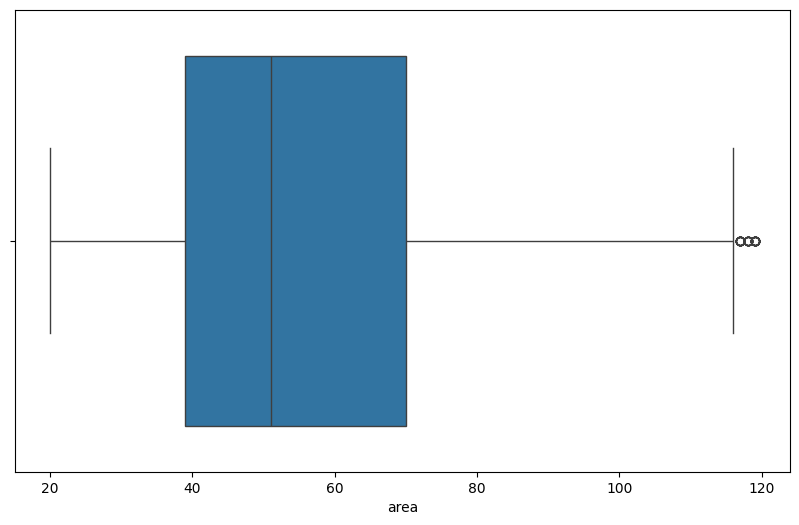

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Engenharia de Features

### Removendo Coluna "rent"

In [44]:
df_clean = df.drop(columns='rent')

### Criando coluna "price_m2"

In [45]:
df["price_m2"] = df["total"] / df["area"]
df.price_m2.describe()

count    9294.000000
mean       60.371835
std        36.657964
min         9.650000
25%        36.808292
50%        50.782468
75%        73.335882
max      1112.916667
Name: price_m2, dtype: float64

### Criando coluna "price_level"

In [46]:
bins = [9, 37, 52, 75, 1115]
labels = ["Baixo", "Medio", "Alto", "Muito Alto"]

df["price_level"] = pd.cut(
    df["price_m2"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

#### Removendo linhas com NaN na feature target

In [47]:
df = df.dropna(subset=["price_level"])

#### Verificando a distribuição

price_level
Medio         2474
Baixo         2351
Alto          2244
Muito Alto    2225
Name: count, dtype: int64


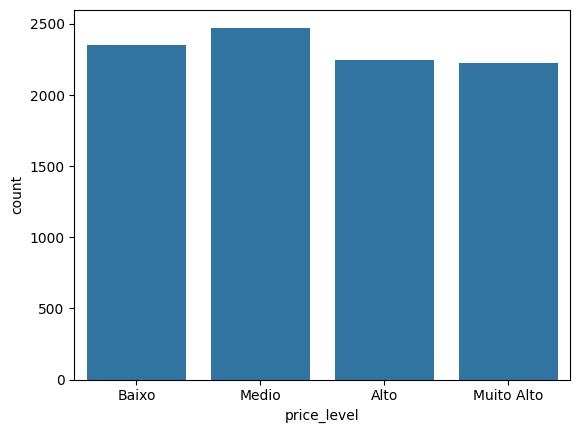

In [48]:
sns.countplot(x = df['price_level'])
print(df["price_level"].value_counts())

## Divisão entre previsores (X) e classe (y)

In [49]:
target = "price_level"
X = df.drop(columns=[target])
y = df[target]

#### Separando variaveis entre numericas e categoricas

In [50]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

##  Escalonamento dos valores e Codificação de variáveis categóricas

### Criando pipeline de Transformer

In [ ]:
# Normalizando as variaveis Numericas

# Se ainda tiver valores ausentes é aplicado a estrategia de Mediana
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Transformando variaveis categoricas em numericas atraves do OneHotEncoder

# Se ainda tiver valores ausentes é aplicado a estrategia de Moda
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

## Divisão da Base em treinamento, teste

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

###  Transformer para converter sparse -> dense (para Naive Bayes)

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()

## Invocando modelos

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "SVM": SVC(class_weight="balanced", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    # "NeuralNetwork": MLPClassifier(max_iter=500, random_state=42), # Demora muito...trava computador
    "NaiveBayes": GaussianNB()
}

### Treinamento e validação 


==================== LogisticRegression ====================


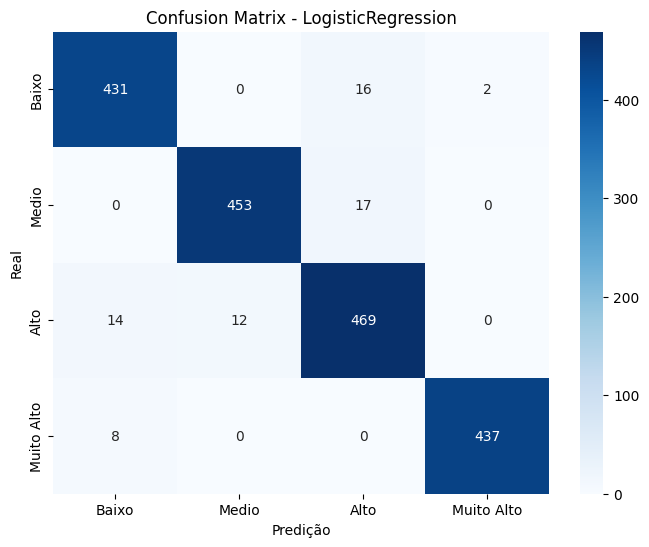


Classification Report for LogisticRegression:
              precision    recall  f1-score   support

       Baixo       0.95      0.96      0.96       449
       Medio       0.97      0.96      0.97       470
        Alto       0.93      0.95      0.94       495
  Muito Alto       1.00      0.98      0.99       445

    accuracy                           0.96      1859
   macro avg       0.96      0.96      0.96      1859
weighted avg       0.96      0.96      0.96      1859


==================== RandomForest ====================


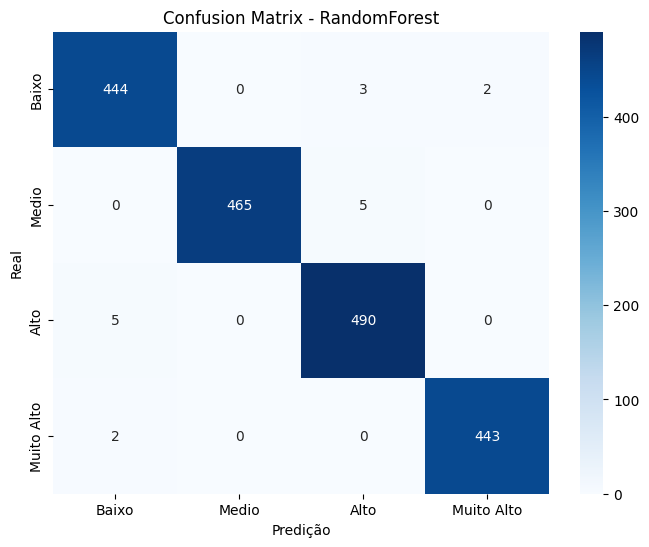


Classification Report for RandomForest:
              precision    recall  f1-score   support

       Baixo       0.98      0.99      0.99       449
       Medio       1.00      0.99      0.99       470
        Alto       0.98      0.99      0.99       495
  Muito Alto       1.00      1.00      1.00       445

    accuracy                           0.99      1859
   macro avg       0.99      0.99      0.99      1859
weighted avg       0.99      0.99      0.99      1859


==================== SVM ====================


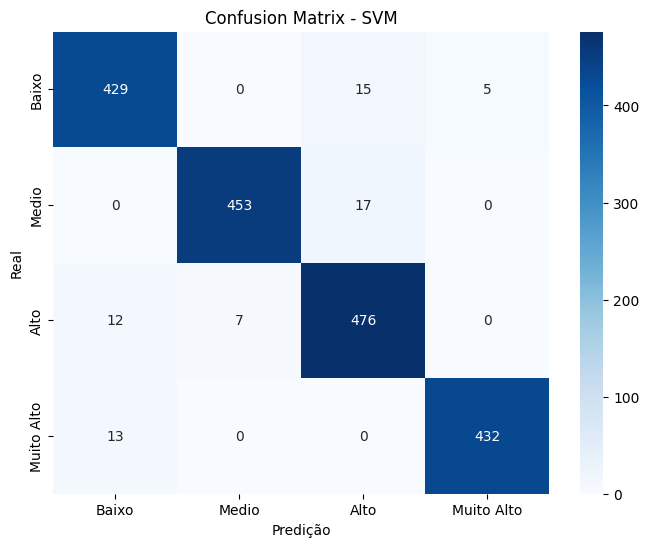


Classification Report for SVM:
              precision    recall  f1-score   support

       Baixo       0.94      0.96      0.95       449
       Medio       0.98      0.96      0.97       470
        Alto       0.94      0.96      0.95       495
  Muito Alto       0.99      0.97      0.98       445

    accuracy                           0.96      1859
   macro avg       0.96      0.96      0.96      1859
weighted avg       0.96      0.96      0.96      1859


==================== KNN ====================


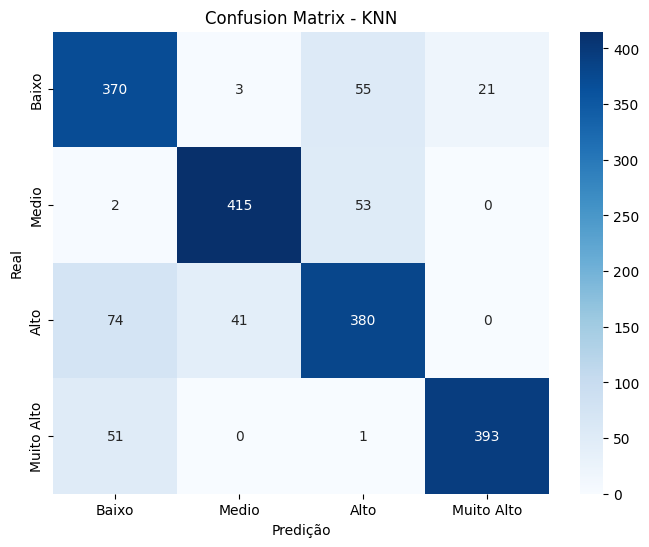


Classification Report for KNN:
              precision    recall  f1-score   support

       Baixo       0.74      0.82      0.78       449
       Medio       0.90      0.88      0.89       470
        Alto       0.78      0.77      0.77       495
  Muito Alto       0.95      0.88      0.92       445

    accuracy                           0.84      1859
   macro avg       0.84      0.84      0.84      1859
weighted avg       0.84      0.84      0.84      1859


==================== DecisionTree ====================


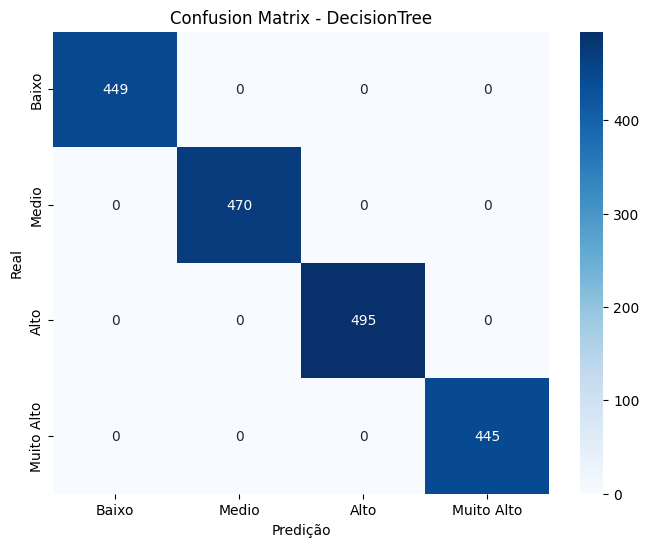


Classification Report for DecisionTree:
              precision    recall  f1-score   support

       Baixo       1.00      1.00      1.00       449
       Medio       1.00      1.00      1.00       470
        Alto       1.00      1.00      1.00       495
  Muito Alto       1.00      1.00      1.00       445

    accuracy                           1.00      1859
   macro avg       1.00      1.00      1.00      1859
weighted avg       1.00      1.00      1.00      1859


==================== NaiveBayes ====================


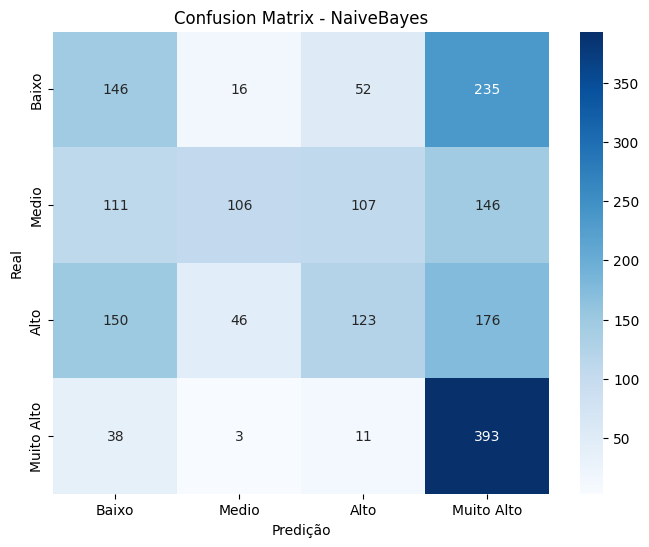


Classification Report for NaiveBayes:
              precision    recall  f1-score   support

       Baixo       0.33      0.33      0.33       449
       Medio       0.62      0.23      0.33       470
        Alto       0.42      0.25      0.31       495
  Muito Alto       0.41      0.88      0.56       445

    accuracy                           0.41      1859
   macro avg       0.45      0.42      0.38      1859
weighted avg       0.45      0.41      0.38      1859



In [56]:
for name, model in models.items():
    print(f"\n==================== {name} ====================")
    
    # Cria e treina o pipeline
    if name == "NaiveBayes":
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("to_dense", DenseTransformer()), 
            ("classifier", model)
        ])
    else:
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # --- Matriz de Confusão Visual ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6)) # Define o tamanho da figura
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # --- Relatório de Classificação ---
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=labels))
    print("=" * 52)

### Usando Cross Validation